In [27]:
import numpy as np
from scipy.special import jv, yv, spherical_jn
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import math
from functools import partial

# Bessel Function - Sum definition (Taylor around zero)

Here I implement the Bessel function with the sum definition and a for loop. Same is done below but with tensors and without a loop. (formula from wikipedia)

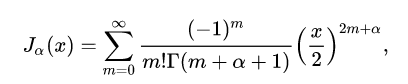

## Implementation 1 - For Loop

The lgamma function in tensorflow is the logarithm of the actual gamma function, which is why I take the exponential. Also, gamma of n is the factorial of n-1 so I can use the gamma function to calculate the m! as well

In [2]:
def Bessel(n,x):
    
    result = tf.zeros(len(x), dtype=tf.double)
    cache = tf.zeros(len(x), dtype=tf.double)
    
    for i in range(1000):
        
        tf.cast(i, dtype=tf.double)
        intermediate = (-1.)**i / (tf.cast(tf.exp(tf.math.lgamma(i+1.0)), dtype=tf.double) * tf.cast(tf.exp(tf.math.lgamma(i + n + 1.0)), dtype=tf.double)) * (x/2)**(2.0*i+n)
        cache = result + intermediate
        #print(cache)
        result = tf.where(tf.math.is_nan(cache), result, cache)
        
    return result

Here I check the agreement with the bessel function from scipy. For lower argument values the agreement is good but the higher the values get the higher the deviation. This can also be seen below in the plot where there is good agreement until approx. 15 and then the lines start to diverge. 

I tried several orders and it always seems to diverge starting at values between 12 and 16. Which makes sense since the sum is the taylor approximation around zero.

Increasing the upper limit for the sum doesn't change much. I tried going from 100 to 10e3 to 10e4 to 10e6 to 10e8, where it then already started getting slower when calculating but the result wasn't better.

Probably even higher upper limits would give better results but also take a lot more time for comparatively very little improvement

In [3]:
argument = tf.constant([8.0,20.], dtype=tf.double)
order = tf.constant([3.5], dtype=tf.double)

print(jv(order, argument))
print(Bessel(order, argument))
print(jv(order, argument))

2021-12-06 09:56:20.715912: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-12-06 09:56:20.717679: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


[-0.23256799  0.02151782]
tf.Tensor([-0.23256738  0.26359259], shape=(2,), dtype=float64)
[-0.23256799  0.02151782]


tf.Tensor(
[       nan 1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.00000002 1.00000007
 1.00000026], shape=(13,), dtype=float64)
tf.Tensor([ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12.], shape=(13,), dtype=float64)


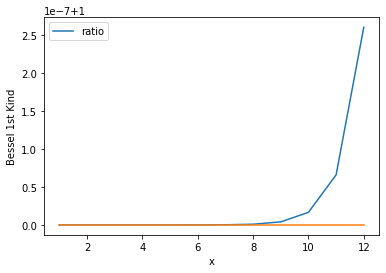

In [4]:
x = tf.cast(tf.range(0.,13.,1), dtype=tf.float64)
order = tf.constant([14.5], dtype=tf.float64)

plt.figure()
#plt.plot(x,jv(order,x), label='scipy')
#plt.plot(x,Bessel(order,x), label='implementation')
plt.plot(x,Bessel(order,x)/jv(order,x), label='ratio')
plt.plot(x,x/x)
plt.legend()
plt.xlabel('x')
plt.ylabel('Bessel 1st Kind')

print(Bessel(order,x)/jv(order,x))
print(x)

The higher the order the higher the arguments can seem to get before the curves start diverging. So this implementation works mainly for small arguments and better for smaller arguments of higher orders

we can go to a radius of 1050 which gives a max x=12 (approx) which will give 4% error if the order is 2.5 and the argument is 12. all the other errors will be less than 1%

## Implementation 2 - Tensors

Here I implement the Bessel functions with the same sum-formula from above but instead of a loop I am using a tensor and then summing over the entries. This seems to be much faster and gives the exact same results (see plot below). However, compared to the Bessel-functions implemented in scipy it only fits for low arguments (which makes sense since the sum expression is the Taylor-series around zero and I cannot sum to infinity)

In [5]:
def Bessel1(n,x):
    
    index = tf.range(0,10000,1.0)
    x = x[:,tf.newaxis]
    
    intermediate = (-1)**index / (tf.exp(tf.math.lgamma(index+1.0)) * tf.exp(tf.math.lgamma(index + n + 1.0))) * (x/2)**(2.0*index+n)
    #print(intermediate)
    intermediate = tf.where(tf.math.is_nan(intermediate), 0., intermediate)
    #print(intermediate)
    intermediate = tf.where(tf.math.is_inf(intermediate), 0., intermediate)
    #print(intermediate)
    result = tf.reduce_sum(intermediate,1)
        
    return result

### Positive orders

[ 0.13002552 -0.14960457]
tf.Tensor([ 0.13671875 -0.14960432], shape=(2,), dtype=float32)


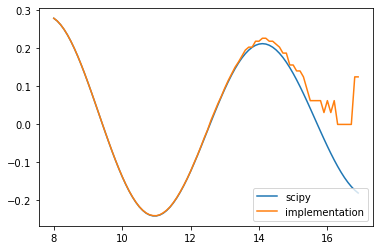

In [6]:
order = tf.constant([0.5])
argument = tf.constant([13.2,3.5])

print(jv(order,argument))
#print(Bessel(order,argument))
print(Bessel1(order,argument))

x = tf.range(8,17,0.1)

plt.figure()
plt.plot(x,jv(order,x), label='scipy')
plt.plot(x,Bessel1(order,x), label='implementation')
#plt.plot(x,Bessel(order,x), label='implementation')
plt.legend()

### Negative Integer Orders

If I want to use the sum approximation I can have a maximum size parameter of approx. 15 (very optimistic case). meaning at a wavelength of 532nm I can have a maximum particle radius of approx. 1270nm. (Versus up to 3500nm which we want to have)

Also, for negative orders the sum approximation is even worse and doesn't seem to give a good approximation at all, see below

It first seems that there might just be a constant shift, but when looking closer, this doesn't hold true.

[-0.21960269  0.2044053 ]
tf.Tensor([-0.21936035  0.20440531], shape=(2,), dtype=float32)
tf.Tensor(
[ 1.0000001   1.          1.0000001   1.          1.          1.0000001
  0.99999994  1.          1.0000001   1.0000001   1.          1.
  1.          1.          1.0000002   1.          0.99999994  1.0000001
  1.0000001   1.0000001   1.          1.0000001   1.0000001   1.0000002
  0.9999998   1.          1.          0.9999999   0.9999999   1.0000002
  1.          1.          1.0000004   1.0000002   1.0000001   1.0000007
  1.0000001   1.0000006   1.          1.0000005   1.0000001   1.0000002
  1.0000013   1.0000013   1.0000012   1.0000005   1.000002    1.0000004
  1.0000004   1.0000025   1.0000032   1.0000067   1.0000058   1.0000066
  1.0000069   1.0000056   1.0000094   1.0000135   1.0000002   1.000028
  1.0000333   1.0000522   1.0000672   1.0001261   1.0000932   1.0005066
  0.9974067   0.99951655  0.9997272   0.99979526  0.99983734  0.99989575
  0.9998884   0.99985904  0.9998582   0.99

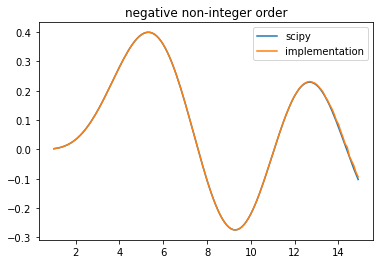

In [7]:
order = tf.constant([-4.])
argument = tf.constant([10,3.5])

print(jv(order,argument))
#print(Bessel(order,argument))
print(Bessel1(order,argument))

#To see that the shifting doesn't help use an x interval starting from 5 instead of 1
x = tf.range(1,15,0.1)


plt.figure()
plt.plot(x,jv(order,x), label='scipy')
plt.plot(x,Bessel1(order,x), label='implementation')
#plt.plot(x,Bessel(order,x)-0.6, label='shifted implementation')
plt.legend()
plt.title('negative non-integer order')

print(Bessel1(order,x)/jv(order,x))

### Negative Non-Integer Orders

For negative integer orders however, the implementation seems to give the same results as for normal positive values. This is not optimal since we need negative non-integer values to construct the yn (second kind functions)

[2.3786525e-01 5.2273027e+04]
tf.Tensor([-1.0918655e+00  3.0680260e+04], shape=(2,), dtype=float32)


Text(0.5, 1.0, 'negative integer order')

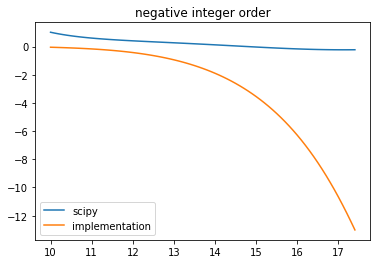

In [8]:
order = tf.constant([-12.5])
argument = tf.constant([13.2,3.5])

print(jv(order,argument))
#print(Bessel(order,argument))
print(Bessel1(order,argument))

x = tf.range(10,17.5,0.1)

plt.figure()
plt.plot(x,jv(order,x), label='scipy')
plt.plot(x,Bessel1(order,x), label='implementation')
#plt.plot(x,Bessel(order,x), label='implementation')
plt.legend()
plt.title('negative integer order')

Here only a quick calculation on what size I can have if I want to stay below values of 15 to use the sum (keep in mind this will only be for positive orders since the sum gives bad results for negative orders)

In [9]:
r=1270

2*np.pi*r/532

14.999333346086607

# Bessel Function - Integral Definition

Another possibility would be to use this integral definition for non-integer alpha. (which we need because the spherical bessel functions are defined as n+1/2 orders with n integer) However, tensorflow has no integral operator so this would have to be approximated by for example trapezoid methods or sth. similar. Question then is how precise this will be.

This is still an open question and I haven't tried to implement it yet. (formula also from wikipedia)

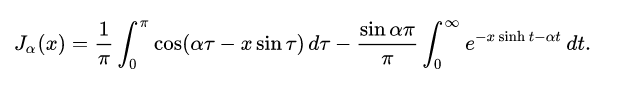

In [10]:
def trapz(function,start,end,N=50):

    x = np.linspace(start,end,N+1) # N+1 points make N subintervals
    y = function(x)
    y_right = y[1:] # right endpoints
    y_left = y[:-1] # left endpoints
    dx = (end - start)/N
    T = (dx/2) * np.sum(y_right + y_left)
    return T

In [11]:
def integrand1(tau, order, variable):
    return np.cos(order*tau - variable*np.sin(tau))

def integrand2(t, order, variable):
    return np.exp(-variable*np.sinh(t)-order*t)

order1 = -5.5
argument1 = 1

i1 = partial(integrand1, order=order1, variable = argument1)
i2 = partial(integrand2, order=order1, variable = argument1)

part11 = trapz(i1, 0, np.pi/4, 10000000)
part12 = trapz(i1, np.pi/4, np.pi/2, 10000000)
part13 = trapz(i1, np.pi/2, 3*np.pi/4, 10000000)
part14 = trapz(i1, 3*np.pi/4, np.pi, 10000000)
part1 = part11 + part12 + part13 + part14
part2 = trapz(i2, 0, 100, 10000)

besselapprox = part1/np.pi - np.sin(order1*np.pi)*part2/np.pi

print(besselapprox/jv(order1,argument1))


0.9999999850317869


Doesn't seem to work either. Values are very unstable depending on argument-order combination. Sometimes there is a very good agreement, sometimes not. Probably this is because of the trigonometric functions which start oscillating rapidly depending on argument and hence the trapez-method will have difficulty.

# Spherical Bessel Function - Scipy Implementation - 1

Line 16 in 

https://github.com/scipy/scipy/blob/57bf4d674c6d31ce5e070498c8cbdc0f2ea8c8d6/scipy/special/tests/test_spherical_bessel.py#L14

has the link to the equation below (https://dlmf.nist.gov/10.49.E3) and comes from the scipy Tests of spherical Bessel functions file. However, they also write in the comments that: Note: exact expression is numerically stable only for small n or z >> n

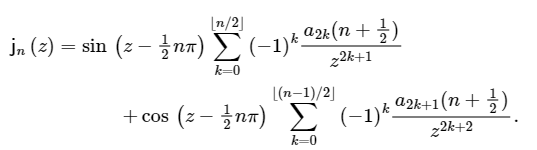

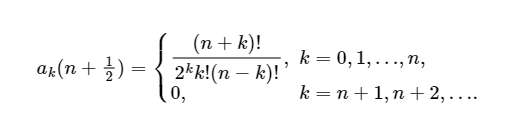

For z approaching zero we have (https://dlmf.nist.gov/10.52#i), which can be found in line 64 from the above github link

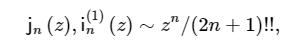

Not implemented yet.

This next part is for the argument approaching zero. Gives good results but - obviously - only for very small arguments. Arguments which are to small for our purposes, so for < 1 arguments at least.

In [12]:
from functools import reduce # only in Python 3

def doublefactorial(n):
    return reduce(int.__mul__, range(n, 0, -2))

order = 80
argument = 0.8

print(spherical_jn(order,argument)/(argument**order/doublefactorial(2*order+1)))

0.998038712300157


# Spherical Bessel Function - Derivative/Sum Implementation - 2

Here (https://mathworld.wolfram.com/SphericalBesselFunctionoftheFirstKind.html) and also here for the derivatives 

(https://reader.elsevier.com/reader/sd/pii/B9780080443713500065?token=43F2A8B9CD7C5728570C1D411BA29C4505E56AA989AD5967760EDDDC067836D93BD201EBA8B1F5C6F3E66BC2A19874C8&originRegion=eu-west-1&originCreation=20211128131124)

we find another way to implement the spherical bessel functions directly. The derivative form (last line) was already tried and is not feasible for higher orders since it would take way to long to calculate. However, the sum representation in the first or second line could be worth a try.

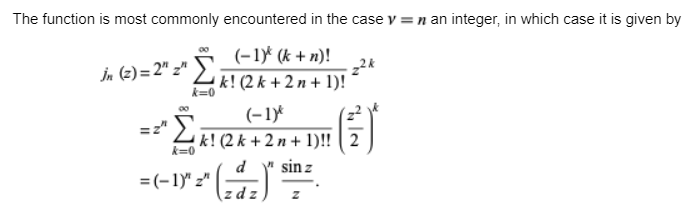

Implementing this sum seems to give similar problems to the method above. (probably this is the same sum as above just rewritten for the spherical bessel functions directly, I didn't check/calculate it) So here as well we get good agreement for small values of the argument but starting at arguments 10 and higher the curves start diverging again, seemingly independent of order. However, there is a tendency that at higher and higher orders the curves start to diverge earlier.

In [25]:
def besselfunction2(n,x):
    
    index = tf.range(0,10000,1.0)
    x1=x
    x = x[:,tf.newaxis]
    
    
    intermediate = (-1)**index * tf.exp(tf.math.lgamma(index+n+1.0)) * x**(2*index) / tf.exp(tf.math.lgamma(index+1.0)) \
    / tf.exp(tf.math.lgamma(2*index+2*n+2.0))
    #print(intermediate)
    intermediate = tf.where(tf.math.is_nan(intermediate), 0., intermediate)
    #print(intermediate)
    intermediate = tf.where(tf.math.is_inf(intermediate), 0., intermediate)
    #print(intermediate)
    result = tf.reduce_sum(intermediate,1)
        
    return result * 2**n * x1**n

scipy:  [ 0.19844795  0.07794219 -0.04785533]
implementation:  tf.Tensor([0.19844794 0.07734299 1.2771187 ], shape=(3,), dtype=float32)


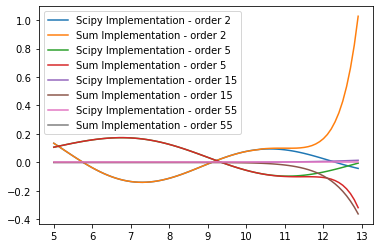

In [14]:
order = np.array([2.])
x = np.arange(5,13,0.1)

plt.figure()

plt.plot(x, spherical_jn(int(order),x), label='Scipy Implementation - order 2')
plt.plot(x, besselfunction2(order,x), label='Sum Implementation - order 2')

plt.plot(x, spherical_jn(int(5),x), label='Scipy Implementation - order 5')
plt.plot(x, besselfunction2(5.,x), label='Sum Implementation - order 5')

plt.plot(x, spherical_jn(int(15),x), label='Scipy Implementation - order 15')
plt.plot(x, besselfunction2(15.,x), label='Sum Implementation - order 15')

plt.legend()


#see how values start getting worse and worse when arguments get bigger
x1 = np.array([2.,10.,13.])
print('scipy: ', spherical_jn(int(order),x1))
print('implementation: ', besselfunction2(order,x1))

tf.Tensor(
[ 0. nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan], shape=(80,), dtype=float32)


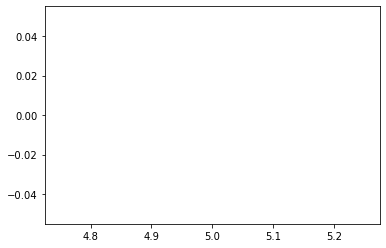

In [26]:
#plt.plot(x, spherical_jn(int(55),x), label='Scipy Implementation - order 55')
plt.plot(x, besselfunction2(55.,x), label='Sum Implementation - order 55')
print(besselfunction2(55.,x))

# Spherical Bessel Function - Recurrence Relation Implementation - 3

Here (https://dlmf.nist.gov/10.51#i) we can find the scipy implementation for arguments bigger than the order. It is somewhat also correct for arguments a bit smaller than the order but this goes only so far. This is not what is needed because in our case the arguments will always be smaller or equal to the order for at least the highest order functions in the sum.

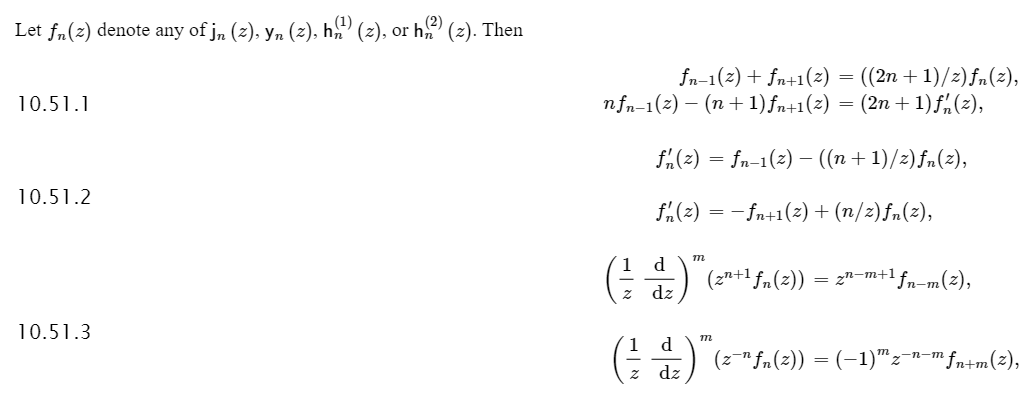

In [142]:
#Implementation using the derivative definition for the spherical bessel functions
def besselrecursion(n,x):
    
    if n >= 2:
        result = (2*(n-1)+1)/x * besselrecursion(n-1,x) - besselrecursion(n-2,x)
    elif n == 1:
        result = np.sin(x)/x**2 - np.cos(x)/x
    elif n == 0:
        result = np.sin(x)/x
    return result

#Alternative definition of the recurrence relation using the implemented jn directly

def besselrecursion1(n,x):
    
    if n >= 2:
        result = (2*(n-1)+1)/x * besselrecursion1(n-1,x) - besselrecursion1(n-2,x)
    elif n == 1:
        result = spherical_jn(1,x)
    elif n == 0:
        result = spherical_jn(0,x)
    return result


#already with order 30 and argument 12 the results differ more than is desirable
z = 5
n = 25
a = besselrecursion(n,z)
print('besselrecursion: ', a)
#print('besselrecursion1: ', besselrecursion1(n,z))
print('bessel implemented in scipy: ', spherical_jn(n,z))
print('Verhältnis: ', a/spherical_jn(n,z))

besselrecursion:  -0.0023613814591325116
bessel implemented in scipy:  7.89093630217965e-17
Verhältnis:  -29925237876780.812


# Bessel Function - Recurrence Relation

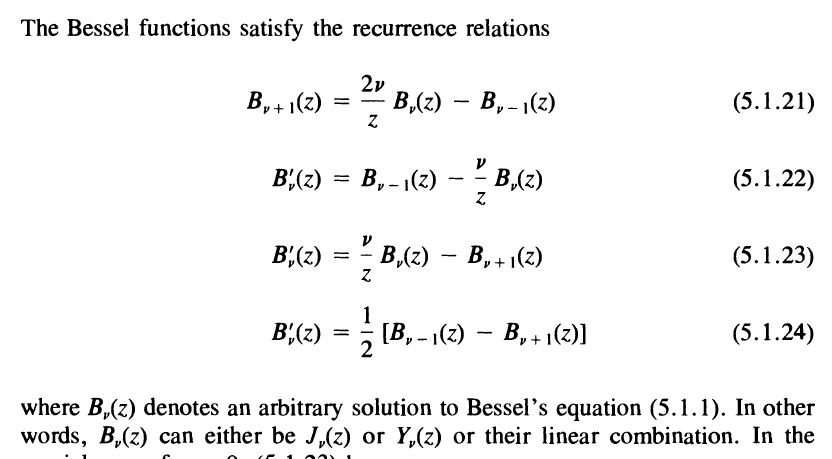

Here as well it seems to be the case that for arguments approaching or higher than the order the results are very good but for lower arguments not at all. I guess this is because according to the scipy documentation the recursion relation is used for higher arguments but something else is used for lower orders (which should give the same result according to me because none of the sources give any conditions on the arguments for the recursion relation) 

(caveat: they say they use the recursion only in the spherical case, this here is the normal bessel function and nothing is said explicitly in the documentation, but since the behavior is the same I guess they use this here as well)

In [119]:
def besselrecursion3(n,x):
    
    if n >= 2:
        result = (2*(n-1))/x * besselrecursion3(n-1,x) - besselrecursion3(n-2,x)
    elif n == 1:
        result = jv(1,x)
    elif n == 0:
        result = jv(0,x)
    return result


#already with order 20 and argument 3 (which is a probable case in our computations)
#the results differ more than is desirable

z = 3
n = 20
print('besselrecursion: ', besselrecursion3(n,z))
print('bessel implemented in scipy: ', jv(n,z))
print('Verhältnis ist: ', besselrecursion3(n,z)/jv(n,z))

besselrecursion:  -0.0006312868287233556
bessel implemented in scipy:  1.2275946737992997e-15
Verhältnis ist:  -514246959682.20294


# Bessel Function - Another Sum

This sum comes from the NIST handbook of mathematical functions

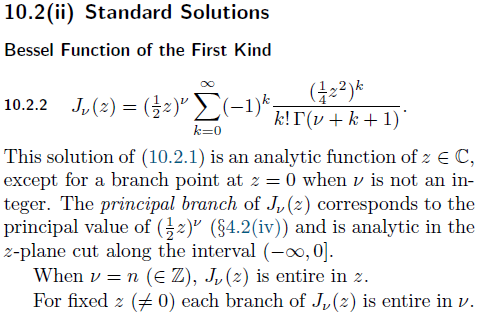

It's the same sum as in the beginning only that they separated out the factor to the power of the order explicitly here.

Check if GradientTape can derive something wrapped in tf.py_function. Sadly, it doesn't work since it seems to treat the wrapped function as a constant even if the argument is the variable.

In [162]:
x = tf.constant(3.0, dtype=tf.float32)
with tf.GradientTape() as g:
  g.watch(x)
  y = x * tf.py_function(jv,inp=[4., x],Tout=tf.float32)
dy_dx = g.gradient(y, x)
print(dy_dx)
print(jv(4,3.))

tf.Tensor(0.13203418, shape=(), dtype=float32)
0.13203418392461216


# Integration

Trapezoid rule from

https://personal.math.ubc.ca/~pwalls/math-python/integration/trapezoid-rule/

with some code examples as well. Rule is implemented below

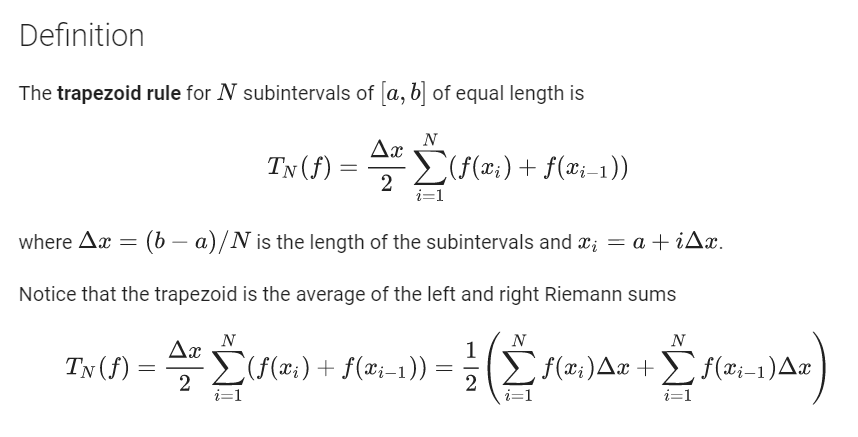

In [179]:
def trapz(function,start,end,N=50):

    x = np.linspace(start,end,N+1) # N+1 points make N subintervals
    y = function(x)
    y_right = y[1:] # right endpoints
    y_left = y[:-1] # left endpoints
    dx = (end - start)/N
    T = (dx/2) * np.sum(y_right + y_left)
    return T

In [216]:
x = 2*np.pi*3500/532

2+x+x**(1/3)

46.79437737217127

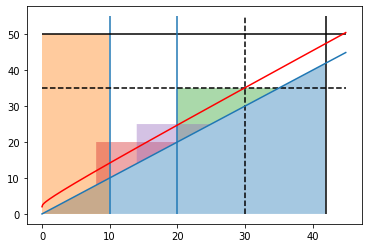

In [187]:
x = np.arange(0,45,0.1)
xfill = np.arange(0,42,0.1)
plt.figure()
plt.plot(x,x)
plt.plot(x,2+x+x**(1/3),color='red')

plt.vlines(10,0,55)
plt.vlines(42,0,55, color='black')
plt.hlines(50,0,45, color='black')
plt.vlines(20,0,55)
plt.hlines(35,0,45, color='black', linestyle='--')
plt.vlines(30,0,55, color='black', linestyle='--')

plt.fill_between(xfill,xfill, alpha=0.4)
plt.fill_between(np.arange(0,10,0.1),np.zeros(100)+50, alpha=0.4)
plt.fill_between(np.arange(20,35,0.1),np.zeros(150)+35,np.arange(20,35,0.1), alpha=0.4)
plt.fill_between(np.arange(8,20,0.1),np.zeros(120)+20,np.arange(8,20,0.1), alpha=0.4)
plt.fill_between(np.arange(14,25,0.1),np.zeros(110)+25,np.arange(14,25,0.1), alpha=0.4)

In [310]:
import tensorflow.python.framework.function as tfp
tf.executing_eagerly()
tf.compat.v1.enable_eager_execution()

ValueError: tf.enable_eager_execution must be called at program startup.

In [294]:
@tfp.Defun(tf.float32)
def MyFunc(x):
    return x*x

In [296]:
x = tf.constant(3.0, dtype=tf.float32)
with tf.GradientTape() as g:
  g.watch(x)
  y = MyFunc(x)
dy_dx = g.gradient(y, x)
print(dy_dx)
print(jv(4,3.))

None
0.13203418392461216


In [299]:
with tf.GradientTape() as tape:
    loss = x*x

grad = tape.gradient(loss, x)
print(grad)

None


In [190]:
2*np.pi*850/532

10.03892389305009

In [175]:
def approx(n,x):
    if (x**2 < n+1):
        return (x/2)**n / tf.exp(tf.math.lgamma(n+1))
    else:
        return 0
    return 0

order = tf.constant(27.)
argument = tf.constant(0.9)

print(jv(order,argument)/approx(order,argument))

tf.Tensor(0.9927952, shape=(), dtype=float32)


From here on I use a radius bound between 10 and 850 nanometers and use the sum definition of the bessel functions.

In [10]:
jv(-5001,100000)

-0.0024916469662959254

[1. 1. 1. ... 1. 1. 1.]


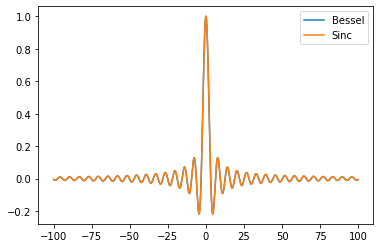

In [15]:
import numpy as np
from scipy.special import jv, yv, spherical_jn
import matplotlib.pyplot as plt

x = np.arange(-100,100,0.1)

plt.figure()
plt.plot(x, spherical_jn(0,x), label='Bessel')
plt.plot(x, np.sin(x)/x, label='Sinc')
plt.legend()

print(spherical_jn(0,x)/(np.sin(x)/x))

# Spherical Bessel Implementation in Tensorflow

In [29]:
def prefactor(n,x):
    exponent = tf.constant(n)
    return (-x)**n

def bessel0(x):
    return tf.sin(x)/x

#def bessel0(x):
 #   return tf.math.bessel_i0e(x)

def bessel1(x):
    with tf.GradientTape() as g:
        g.watch(x)
        
        y = bessel0(x)
        
        j1 = 1/x*g.gradient(y,x)
        
    return prefactor(1.,x)*j1, j1

def bessel2(x):
        with tf.GradientTape() as t1:
            t1.watch(x)
            
            y = bessel1(x)[1]

        j2 = 1/x*t1.gradient(y, x)
    
        return prefactor(2.,x)*j2, j2

def bessel3(x):
    with tf.GradientTape() as t1:
        t1.watch(x)
        
        y = bessel2(x)[1]
        
        j3 = 1/x*t1.gradient(y, x)
    
    return prefactor(3.,x)*j3, j3

def bessel4(x):
    with tf.GradientTape() as t1:
        t1.watch(x)
        
        y = bessel3(x)[1]
        
        j4 = 1/x*t1.gradient(y, x)
    
    return prefactor(4.,x)*j4, j4

def bessel5(x):
    with tf.GradientTape() as t1:
        t1.watch(x)
        
        y = bessel4(x)[1]
        
        j5 = 1/x*t1.gradient(y, x)
    
    return prefactor(5.,x)*j5, j5

def bessel6(x):
    with tf.GradientTape() as t1:
        t1.watch(x)
        
        y = bessel5(x)[1]
        
        j6 = 1/x*t1.gradient(y, x)
    
    return prefactor(6.,x)*j6, j6

def bessel7(x):
    with tf.GradientTape() as t1:
        t1.watch(x)
        
        y = bessel6(x)[1]
        
        j7 = 1/x*t1.gradient(y, x)
    
    return prefactor(7.,x)*j7, j7

def bessel8(x):
    with tf.GradientTape() as t1:
        t1.watch(x)
        
        y = bessel7(x)[1]
        
        j8 = 1/x*t1.gradient(y, x)
    
    return prefactor(8.,x)*j8, j8

def bessel9(x):
    with tf.GradientTape() as t1:
        t1.watch(x)
        
        y = bessel8(x)[1]
        
        j9 = 1/x*t1.gradient(y, x)
    
    return prefactor(9.,x)*j9, j9

def bessel10(x):
    with tf.GradientTape() as t1:
        t1.watch(x)
        
        y = bessel9(x)[1]
        
        j10 = 1/x*t1.gradient(y, x)
    
    return prefactor(10.,x)*j10, j10

def bessel11(x):
    with tf.GradientTape() as t1:
        t1.watch(x)
        
        y = bessel10(x)[1]
        
        j11 = 1/x*t1.gradient(y, x)
    
    return prefactor(11.,x)*j11, j11

def bessel12(x):
    with tf.GradientTape() as t1:
        t1.watch(x)
        
        y = bessel11(x)[1]
        
        j12 = 1/x*t1.gradient(y, x)
    
    return prefactor(12.,x)*j12, j12

def bessel13(x):
    with tf.GradientTape() as t1:
        t1.watch(x)
        
        y = bessel12(x)[1]
        
        j13 = 1/x*t1.gradient(y, x)
    
    return prefactor(13.,x)*j13, j13

def bessel14(x):
    with tf.GradientTape() as t1:
        t1.watch(x)
        
        y = bessel13(x)[1]
        
        j14 = 1/x*t1.gradient(y, x)
    
    return prefactor(14.,x)*j14, j14

def bessel15(x):
    with tf.GradientTape() as t1:
        t1.watch(x)
        
        y = bessel14(x)[1]
        
        j15 = 1/x*t1.gradient(y, x)
    
    return prefactor(15.,x)*j15, j15

def bessel16(x):
    with tf.GradientTape() as t1:
        t1.watch(x)
        
        y = bessel15(x)[1]
        
        j16 = 1/x*t1.gradient(y, x)
    
    return prefactor(16.,x)*j16, j16

def bessel17(x):
    with tf.GradientTape() as t1:
        t1.watch(x)
        
        y = bessel16(x)[1]
        
        j17 = 1/x*t1.gradient(y, x)
    
    return prefactor(17.,x)*j17, j17

def bessel18(x):
    with tf.GradientTape() as t1:
        t1.watch(x)
        
        y = bessel17(x)[1]
        
        j18 = 1/x*t1.gradient(y, x)
    
    return prefactor(18.,x)*j18, j18

def bessel19(x):
    with tf.GradientTape() as t1:
        t1.watch(x)
        
        y = bessel18(x)[1]
        
        j19 = 1/x*t1.gradient(y, x)
    
    return prefactor(19.,x)*j19, j19

def bessel20(x):
    with tf.GradientTape() as t1:
        t1.watch(x)
        
        y = bessel19(x)[1]
        
        j20 = 1/x*t1.gradient(y, x)
    
    return prefactor(20.,x)*j20, j20

def bessel21(x):
    with tf.GradientTape() as t1:
        t1.watch(x)
        
        y = bessel20(x)[1]
        
        j21 = 1/x*t1.gradient(y, x)
    
    return prefactor(21.,x)*j21, j21

def bessel22(x):
    with tf.GradientTape() as t1:
        t1.watch(x)
        
        y = bessel21(x)[1]
        
        j22 = 1/x*t1.gradient(y, x)
    
    return prefactor(22.,x)*j22, j22

def bessel23(x):
    with tf.GradientTape() as t1:
        t1.watch(x)
        
        y = bessel22(x)[1]
        
        j23 = 1/x*t1.gradient(y, x)
    
    return prefactor(23.,x)*j23, j23

def bessel24(x):
    with tf.GradientTape() as t1:
        t1.watch(x)
        
        y = bessel23(x)[1]
        
        j24 = 1/x*t1.gradient(y, x)
    
    return prefactor(24.,x)*j24, j24

def bessel25(x):
    with tf.GradientTape() as t1:
        t1.watch(x)
        
        y = bessel24(x)[1]
        
        j25 = 1/x*t1.gradient(y, x)
    
    return prefactor(25.,x)*j25, j25

def bessel26(x):
    with tf.GradientTape() as t1:
        t1.watch(x)
        
        y = bessel25(x)[1]
        
        j26 = 1/x*t1.gradient(y, x)
    
    return prefactor(26.,x)*j26, j26

def bessel27(x):
    with tf.GradientTape() as t1:
        t1.watch(x)
        
        y = bessel26(x)[1]
        
        j27 = 1/x*t1.gradient(y, x)
    
    return prefactor(27.,x)*j27, j27

def bessel28(x):
    with tf.GradientTape() as t1:
        t1.watch(x)
        
        y = bessel27(x)[1]
        
        j28 = 1/x*t1.gradient(y, x)
    
    return prefactor(28.,x)*j28, j28

def bessel29(x):
    with tf.GradientTape() as t1:
        t1.watch(x)
        
        y = bessel28(x)[1]
        
        j29 = 1/x*t1.gradient(y, x)
    
    return prefactor(29.,x)*j29, j29

def bessel30(x):
    with tf.GradientTape() as t1:
        t1.watch(x)
        
        y = bessel29(x)[1]
        
        j30 = 1/x*t1.gradient(y, x)
    
    return prefactor(30.,x)*j30, j30

In [ ]:
x = tf.range(2.,10.,1.)

plt.figure()
#plt.plot(x, spherical_jn(2,x), label='scipy2')
#plt.plot(x, bessel2(x)[0], '--', label='bessel2')
#plt.plot(x, spherical_jn(3,x), label='scipy3')
#plt.plot(x, bessel3(x)[0], '--', label='bessel3')
plt.plot(x, spherical_jn(19,x), label='scipy4')
%time plt.plot(x, bessel19(x)[0], '--', label='bessel4')
plt.xlabel('argument')
plt.ylabel('function value')
plt.legend()

In [35]:
value = tf.constant(3.)
%time bessel9(value)

CPU times: user 32.5 s, sys: 237 ms, total: 32.8 s
Wall time: 32.8 s


(<tf.Tensor: shape=(), dtype=float32, numpy=-4.2772856e-05>,
 <tf.Tensor: shape=(), dtype=float32, numpy=2.1730862e-09>)

In [53]:
a = 2*np.pi*1500/532

In [54]:
2+a+4*a**(1/3)

30.143239031122896

In [145]:
liste = {
    0: bessel1,
    1: bessel2
}

In [147]:
liste[0]

<function __main__.bessel1(x)>

In [150]:
for order in range(2):
    print(liste[order](tf.constant(3.)))

tf.Tensor(0.3456775, shape=(), dtype=float32)
tf.Tensor(0.2986375, shape=(), dtype=float32)


In [ ]:
jv(0,3.0)
tf.math.bessel_i0e(3.0)